# Smart Charging Using Reinforcement Learning

In [146]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
import numpy as np
#%matplotlib inline

In [147]:
# Define constants
input_size = 4  # time cofficients, battery level, time index, energy demand
output_size = 4 # Number of charging rates (zero, low, medium, high)

In [148]:
class EVChargingState:
    def __init__(self, battery_level, time_index, energy_demand):
        self.battery_level = battery_level
        self.time_index = time_index
        self.energy_demand = energy_demand

    # convert state to tensor for feeding into neural network
    def as_tensor(self):
        return tf.convert_to_tensor([self.battery_level, self.time_index, self.energy_demand], dtype=tf.float32)

In [149]:
class QNetwork(tf.keras.Model):
    def __init__(self, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(32, activation='relu')
        self.fc3 = tf.keras.layers.Dense(output_size, activation=None)

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [150]:
class ExperienceReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
    
    def add(self, experience):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [151]:
def calculate_reward(time_coefficient, remaining_time_intervals, charging_rate, battery_level, energy_demand):
    recharging_cost = time_coefficient*np.exp(charging_rate)
    new_battery_level = battery_level + charging_rate

    penalty = 0.0
    if remaining_time_intervals == 0 and new_battery_level < energy_demand:
        penalty = -1000.0
    reward = -recharging_cost + penalty
    return reward, new_battery_level

In [152]:
class EVChargingEnvironment:
    def __init__(self, time_intervals, charging_rates, time_coefficients, energy_demand, battery_capacity):
        self.time_intervals = time_intervals
        self.charging_rates = charging_rates
        self.time_coefficients = time_coefficients
        self.energy_demand = energy_demand
        self.battery_capacity = battery_capacity
        
        self.current_time_index = 0
        self.current_battery_level = battery_capacity // 2  # Starting battery level
        
    def reset(self):
        self.current_time_index = 0
        self.current_battery_level = self.battery_capacity // 2
        return EVChargingState(self.current_battery_level, self.current_time_index, self.energy_demand)
    
    def step(self, action):
        # Ensure valid action
        if action < 0 or action >= len(self.charging_rates):
            raise ValueError("Invalid action")
        
        # Get current time coefficient and charging rate
        time_coefficient = self.time_coefficients[self.current_time_index]
        charging_rate = self.charging_rates[action]

        # Get remaining time intervals
        remaining_time_intervals = (self.current_time_index + 1) % len(self.time_intervals)
        
        # Calculate reward
        reward, new_battery_level = calculate_reward(time_coefficient, remaining_time_intervals, charging_rate, self.current_battery_level, self.energy_demand)
        
        # Update battery level
        self.current_battery_level = max(0, min(new_battery_level, self.battery_capacity))

        # Update time index
        self.current_time_index = (self.current_time_index + 1) % len(self.time_intervals)
        
        # Check if simulation is complete
        done = self.current_time_index == 0
        
        next_state = EVChargingState(self.current_battery_level, self.current_time_index, self.energy_demand)
        return next_state, reward, done


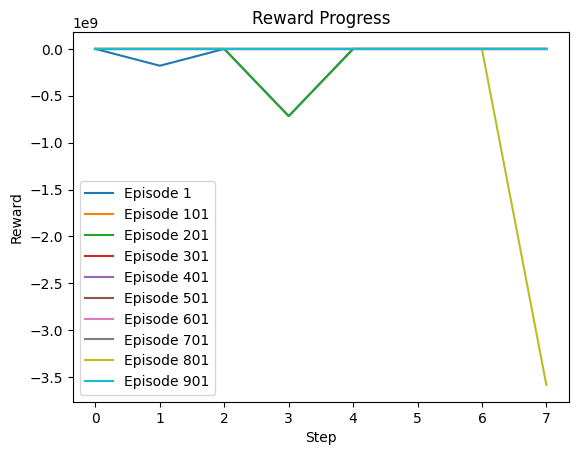

In [153]:
learning_rate = 0.001
discount_factor = 0.95
num_episodes = 1000
target_update_freq = 10
batch_size = 32
replay_buffer_capacity = 1000

#define constants
output_size = 4 # Number of charging rates (zero, low, medium, high)

# Create environment instance
time_intervals = [0, 1, 2, 3, 4, 5, 6, 7]
charging_rates = [0.0, 5.5, 11, 22]

#  We start with lower time coefficient, because the cost is more important in the end, when energy demand is probably already reached
time_coefficients = [0.03, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
battery_capacity = 100

# Create Q-network and target network
q_network = QNetwork(output_size)
target_network = QNetwork(output_size)
target_network.set_weights(q_network.get_weights())
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Create experience replay buffer
replay_buffer = ExperienceReplayBuffer(replay_buffer_capacity)

env = EVChargingEnvironment(time_intervals, charging_rates, time_coefficients, energy_demand, battery_capacity)

plt.ion()
fig, ax = plt.subplots()
ax.set_xlabel("Step")
ax.set_ylabel("Reward")
ax.set_title("Reward Progress")

all_episode_rewards = []

# Training loop
for episode in range(num_episodes):
    # Initialize an empty list to store episode rewards
    episode_rewards = []
    state = env.reset()
    done = False

    # Parameters for normal distribution
    mu = 30.0  # Mean in kWh
    sigma = 5.0  # Standard deviation in kWh

    # Generate energy demand using a normal distribution
    energy_demand = np.random.normal(mu, sigma)

    while not done:
        state_tensor = tf.convert_to_tensor(state.as_tensor())
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        
        # Choose action using epsilon-greedy policy
        epsilon = 0.1
        if np.random.rand() < epsilon:
            action = np.random.choice(output_size)
        else:
            q_values = q_network(state_tensor)
            action = np.argmax(q_values.numpy())
        
        # Perform action in the environment
        next_state, reward, done = env.step(action)
        next_state_tensor = tf.convert_to_tensor(next_state.as_tensor())
        next_state_tensor = tf.expand_dims(next_state_tensor, axis=0)
        
        # Calculate target and loss
        target_q_values = target_network(next_state_tensor)
        max_target_q = np.max(target_q_values.numpy())

        target = reward + discount_factor * max_target_q
        target = tf.constant(target, dtype=tf.float32)
        target = tf.reshape(target, (1, 1))

        
        with tf.GradientTape() as tape:
            # Given q_values, action, and target
            q_values = q_network(state_tensor)
            current_q = q_values[0, action]
            current_q = tf.reshape(current_q, (1, 1))

            loss = tf.losses.mean_squared_error(target, current_q)
        
        # Update Q-network
        gradients = tape.gradient(loss, q_network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
        
        # Update target network periodically
        if episode % target_update_freq == 0:
            target_network.set_weights(q_network.get_weights())
        
        # Store experience in replay buffer
        replay_buffer.add((state, action, reward, next_state))
        
        state = next_state

        episode_rewards.append(reward)

    all_episode_rewards.append(episode_rewards)

# Define step size for plotting
plot_step_size = 100  # Plot every 100 episodes

# Plot a subset of episode rewards together
for episode in range(0, num_episodes, plot_step_size):
    rewards = all_episode_rewards[episode]
    ax.plot(rewards, label=f"Episode {episode + 1}")

# Add a legend and keep the plot open until it's manually closed
ax.legend()
plt.ioff()
plt.show()